In [17]:
import pandas as pd
import re
import string
import nltk
import numpy as np
from collections import OrderedDict 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
'''To run the following code, please ensure that the NLTK library has been downloaded - if there is an error in the 
    above code, please ensure that you have installed NLTK via conda install using the line below'''
#conda install -c anaconda nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\61413\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The Model
----------

In [3]:
def clean_text(comment):
    '''
    The following code seperates text reviews into tokens, and removes all frequently used words, capitalisation and 
    punctuation. 
    
    INPUT:
    - comment: A text review, in string format
    
    OUTPUT:
    - clean_comment: A clean text review, in string format, without any frequently used words, capitalisation and 
                     punctuation
    '''
    #stopwords contain the most frequently used words in english
    stopwords = nltk.corpus.stopwords.words("english")
    
    clean_comment=""
    #for each review, find the tokens
    tokens = re.split('\W+', comment)
    for word in tokens:
        #remove the commonly used words and punctuations
        if (word.lower() not in stopwords) and (word.lower() not in string.punctuation):
            clean_comment += word.lower() + " " 
    return clean_comment 

In [4]:
def preprocess_text(text_data, meta_data):
    '''
    The following code reads in 2 .csv files containing text reviews and meta-data (including target class of rating)
    respectively - A dataframe is made holding the text reviews and their respective rating.
    Each text review is then cleaned and a third column, clean_review is generated
    
    INPUT:
    - text_data: A .csv file containing only one column with text reviews
    - meta_data: A .csv file containing meta-data and the class column 'rating'
    
    OUTPUT:
    - df: A dataframe holding the text review, clean text review and rating value
    '''
    #read in the .csv file with the reviews
    df=pd.read_csv(text_data)
    
    #save reviews from meta file
    df1=pd.read_csv(meta_data)
    df['rating']=df1.loc[:,'rating']
    
    #clean the review text data so it can be better processed in later stages
    df['clean_review']=""
    for review_index in df.iloc[:, 0].index:
        df.loc[review_index,'clean_review'] = clean_text(df.loc[review_index,'review'])
    return df

In [5]:
df = preprocess_text("review_text_train.csv","review_meta_train.csv")

In [8]:
def train_text(X, y):
    '''
    The following code creates a pipeline of transformations to fit data X and y to a TF-IDF Vectorizer and a Linear SVC 
    consecutively. 
    The Term Frequency - Inverse Document Frequency (TF-IDF) Vectorizer is used to create a bag of words and associate a 
    higher weight to words that are more important to a corpus (determined by term frequency offset by frequency in 
    document)
    The Linear Support Vector Classifier (LinearSVC) is used to determine the parameters of a hyperplane to best seperate
    classes across the multiple features generated in the TF-IDF Vectorizer. 
    
    INPUT:
    - X: An array of (clean) reviews
    - y: An array of classes/ratings for each review in X
    
    OUTPUT:
    - model: A TF-IDF Vectorizer and a LinearSVC fitted to the input data X and y. 
    '''
    pipeline=Pipeline([('vect', TfidfVectorizer(ngram_range=(1,3))),
                  ('clf', LinearSVC(penalty='l1', max_iter=10000, dual=False))]) 
    
    model=pipeline.fit(X, y)
    
    return model

In [10]:
model = train_text(df['clean_review'], df['rating'])

In [41]:
def predict_text(df, model, X_test):
    '''
    The following code displays the top 10 words associated with each rating class to help the user determine whether the 
    model has been reasonably well trained. It also makes a prediction for the input test data.
    
    INPUT:
    - df: A dataframe where the model predictions should be kept - this should be the same dataframe containing the reviews,
          clean reviews and original ratings. 
    - model: A pipeline output containing atleast two steps with the names 'vect' - a TF-IDF Vectorizer and 'clf' - a 
             linear SVC
    - X_test: An array of reviews that need to be classified by the model
    
    OUTPUT:
    - df: Input dataframe with column 'predicted_rating' - holding the model predictions for each test instance
    '''
   #extract the steps of the pipeline
    vectorizer=model.named_steps['vect']
    clf=model.named_steps['clf']
    
    #get all possible features from the vectorizer
    feature_names=vectorizer.get_feature_names()

    #save as numpy array
    feature_names=np.asarray(feature_names)
    
    #determine if the model classification is reasonable by assessing if the top 10 words link to a reasonable score
    target_names=['1', '3', '5']
    for i, label in enumerate(target_names):
        top10=np.argsort(clf.coef_[i])[-10:]
        print("%s star: %s" % (label, " ".join(feature_names[top10])))

    #predict a rating for an X_test set
    df['predicted_rating']=model.predict(X_test)
    
    return df

In [12]:
df=predict_text(df, model, df['review'])

1 star: never return never go terrible zero awful one star horrible tasteless rude worst
3 star: underwhelmed get wrong okay meh overall good would return ok however hit miss three stars
5 star: perfectly awesome fantastic heaven well worth best perfect delicious amazing wait go back


In [13]:
def evaluate_text(model, X_test, y_test):
    '''
    Find the prediction score of the model with test data
    
    INPUT:
    - model: A pipeline output containing atleast two steps with the names 'vect' - a TF-IDF Vectorizer and 'clf' - a 
             linear SVC
    - X_test: An array of reviews that need to be classified by the model
    - y_test: An array of ratings, corresponding to each review in X_test
    
    OUTPUT:
    - score: The accuracy of the model against the test data
    '''
    return model.score(X_test, y_test)

In [14]:
evaluate_text(model, df['review'], df['rating'])

0.8987815305686191

Testing the Model
-------------

In [47]:
df_test=pd.read_csv("review_text_test.csv")
df_test=predict_text(df_test, model, df_test['review'])
df_test.to_csv("C:\\Users\\61413\\Documents\\Machine Learning\\Assignment2\\A2_prediction14.csv")

1 star: zero never go never return terrible awful one star tasteless horrible rude worst
3 star: get wrong decent overall good okay meh would return ok however hit miss three stars
5 star: perfectly awesome heaven fantastic well worth best perfect delicious amazing wait go back


Test the Accuracy Given a Variation in Feature Dimensionality
---------------------------------------

Text(0.5, 0, 'Number of Features')

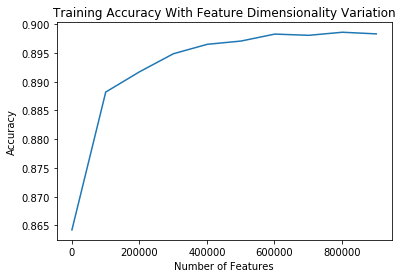

In [18]:
def test_kval_train_text(X, y, k_val):
    '''
    The following code is used to test the accuracy when varying feature dimensionality.
    It creates a pipeline of transformations to fit data X and y to a TF-IDF Vectorizer and a Linear SVC consecutively. 
    The Term Frequency - Inverse Document Frequency (TF-IDF) Vectorizer is used to create a bag of words and associate a 
    higher weight to words that are more important to a corpus (determined by term frequency offset by frequency in 
    document)
    The Linear Support Vector Classifier (LinearSVC) is used to determine the parameters of a hyperplane to best seperate
    classes across the multiple features generated in the TF-IDF Vectorizer. 
    
    INPUT:
    - X: An array of (clean) reviews
    - y: An array of classes/ratings for each review in X
    - k_val: A value for the number of target features that should be selected
    
    OUTPUT:
    - model: A TF-IDF Vectorizer and a LinearSVC fitted to the input data X and y. 
    '''
    pipeline=Pipeline([('vect', TfidfVectorizer(ngram_range=(1,3))),
                  ('chi', SelectKBest(chi2, k=k_val)),
                  ('clf', LinearSVC(penalty='l1', max_iter=10000, dual=False))]) 
    
    model=pipeline.fit(X, y)
    
    return model

def test_predict_text(df, model, X_test):
    '''
    The following code makes a prediction for the input test data.
    
    INPUT:
    - df: A dataframe where the model predictions should be kept - this should be the same dataframe containing the reviews,
          clean reviews and original ratings. 
    - model: A pipeline output containing atleast two steps with the names 'vect' - a TF-IDF Vectorizer and 'clf' - a 
             linear SVC
    - X_test: An array of reviews that need to be classified by the model
    
    OUTPUT:
    - df: Input dataframe with column 'predicted_rating' - holding the model predictions for each test instance
    '''
    #predict a rating for an X_test set
    df['predicted_rating']=model.predict(X_test)
    
    return df

#record the accuracy for multiple possible numbers of features
accuracy=[]
for i in range(1000,1001000, 100000):
    #generate a model on i features
    model = test_kval_train_text(df['clean_review'], df['rating'], i)
    #perform prediction on test data
    df=test_predict_text(df, model, df['review'])
    #evaluate the accuracy and append to list
    score=evaluate_text(model, df['review'], df['rating'])
    accuracy.append(score)
    
#plot the accuracy given different numbers of features
plt.plot(range(1000,1001000, 100000) , accuracy)
plt.title("Training Accuracy With Feature Dimensionality Variation")
plt.ylabel("Accuracy")
plt.xlabel("Number of Features")

Test the Accuracy Given Variation in N-Gram Range
---------------------------------------

Text(0.5, 0, 'N-Gram Range: 1-x')

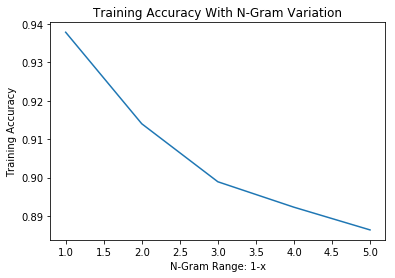

In [53]:
def test_ngram_train_text(X, y, max_ngram):
    '''
    The following code is used to test the accuracy when varying the N-Gram range.
    It creates a pipeline of transformations to fit data X and y to a TF-IDF Vectorizer and a Linear SVC consecutively. 
    The Term Frequency - Inverse Document Frequency (TF-IDF) Vectorizer is used to create a bag of words and associate a 
    higher weight to words that are more important to a corpus (determined by term frequency offset by frequency in 
    document)
    The Linear Support Vector Classifier (LinearSVC) is used to determine the parameters of a hyperplane to best seperate
    classes across the multiple features generated in the TF-IDF Vectorizer. 
    
    INPUT:
    - X: An array of (clean) reviews
    - y: An array of classes/ratings for each review in X
    - max_ngram: The maximum n-gram range to be implemented for the model
    
    OUTPUT:
    - model: A TF-IDF Vectorizer and a LinearSVC fitted to the input data X and y. 
    '''
    pipeline=Pipeline([('vect', TfidfVectorizer(ngram_range=(1,max_ngram))),
                       ('clf', LinearSVC(penalty='l1', max_iter=10000, dual=False))]) 
    
    model=pipeline.fit(X, y)
    
    return model


def test_ngram_predict_text(df, model, X_test):
    '''
    The following code makes a prediction for the input test data.
    
    INPUT:
    - df: A dataframe where the model predictions should be kept - this should be the same dataframe containing the reviews,
          clean reviews and original ratings. 
    - model: A pipeline output containing atleast two steps with the names 'vect' - a TF-IDF Vectorizer and 'clf' - a 
             linear SVC
    - X_test: An array of reviews that need to be classified by the model
    
    OUTPUT:
    - df: Input dataframe with column 'predicted_rating' - holding the model predictions for each test instance
    '''
    df['predicted_rating']=model.predict(X_test)
    
    return df

#record the accuracy for multiple possible numbers of features
accuracy=[]
for i in range(1,6):
    #generate a model on with a [1:i] N-Gram range
    model = test_ngram_train_text(df['clean_review'], df['rating'], i)
    #perform prediction on test data
    df=test_ngram_predict_text(df, model, df['review'])
    #evaluate the accuracy and append to list
    score=evaluate_text(model, df['review'], df['rating'])
    accuracy.append(score)

#plot the accuracy given different N-Gram ranges
plt.plot(range(1, 6), accuracy)
plt.title("Training Accuracy With N-Gram Variation")
plt.ylabel("Training Accuracy")
plt.xlabel("N-Gram Range: 1-x")

Distribution of Text Size in Training Data and Training Errors
---------------------------------------

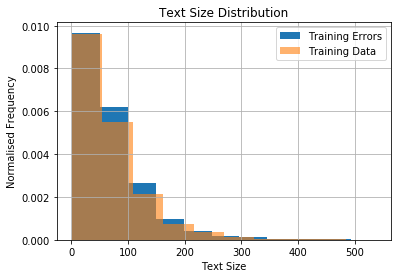

In [40]:
#For each review, find the length of clean_review and add this value to the dataframe
for review in df.iloc[:, 0].index:
    df.loc[review, "clean_review_len"]=len(re.split('\W+', df.loc[review, 'clean_review']))
    
#hold all training classification errors in a list 'errors'
errors=[]
for review in df.iloc[:, 0].index:
    if df.loc[review, 'rating'] != df.loc[review, 'predicted_rating']:
        errors.append(df.loc[review, :])

#Make error list a dataframe and plot a histogram of clean_review_len using a normalised frequency
errors_df=pd.DataFrame(errors)
errors_df=errors_df.reset_index()
errors_df['clean_review_len'].hist(density=True, alpha=1)

#Plot a histogram of clean_review_len of the original training data using a normalised frequency
df['clean_review_len'].hist(density=True, alpha=0.6)
plt.title("Text Size Distribution")
plt.ylabel("Normalised Frequency")
plt.xlabel("Text Size")
plt.legend(["Training Errors", "Training Data"])